<a href="https://www.kaggle.com/code/tousifbnn/oasis-alzheimer-s-detection-cnn?scriptVersionId=235953753" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Classes: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
Balanced dataset size: 1952
Fold 1 Validation Accuracy: 99.23%
Fold 2 Validation Accuracy: 98.72%
Fold 3 Validation Accuracy: 99.74%
Fold 4 Validation Accuracy: 99.74%
Fold 5 Validation Accuracy: 100.00%
Average Validation Accuracy: 99.49%


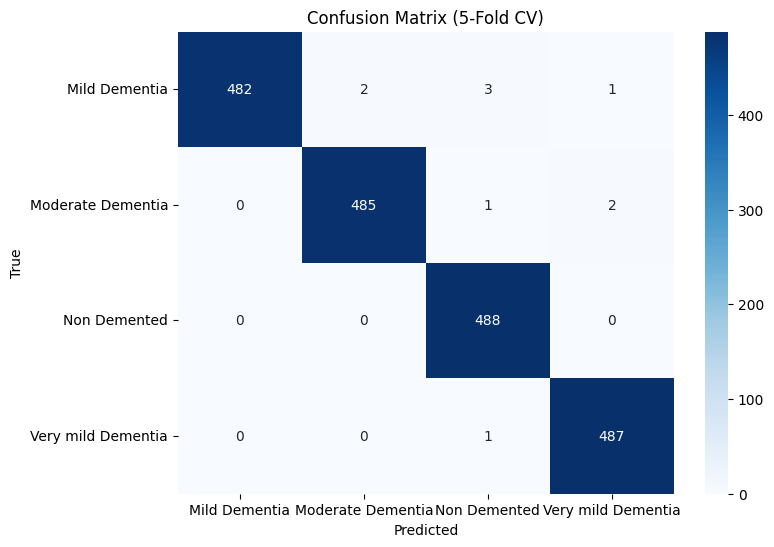


Classification Report:
                    precision    recall  f1-score   support

     Mild Dementia       1.00      0.99      0.99       488
 Moderate Dementia       1.00      0.99      0.99       488
      Non Demented       0.99      1.00      0.99       488
Very mild Dementia       0.99      1.00      1.00       488

          accuracy                           0.99      1952
         macro avg       0.99      0.99      0.99      1952
      weighted avg       0.99      0.99      0.99      1952



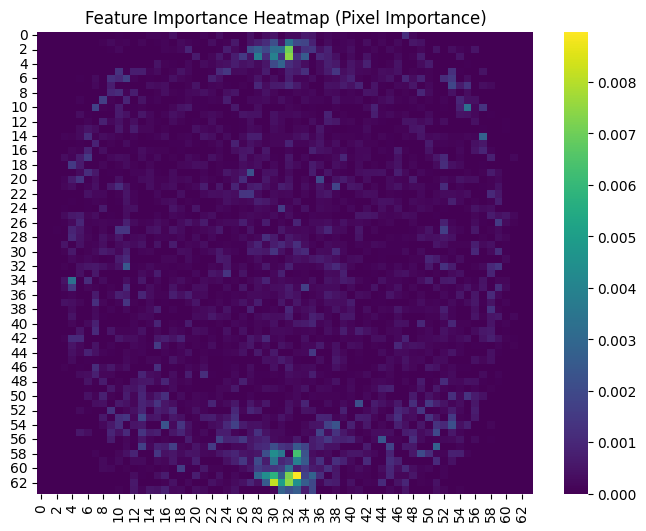

['rf_alzheimer_4classes_cv.pkl']

In [1]:
import torch
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import os

# Copy dataset to working directory for faster I/O
data_dir = '/kaggle/input/imagesoasis/Data'
working_dir = '/kaggle/working/oasis_data'
if not os.path.exists(working_dir):
    shutil.copytree(data_dir, working_dir)
data_dir = working_dir

# Transforms with augmentation for training
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load dataset without transform initially
original_dataset = datasets.ImageFolder(root=data_dir, transform=None)
class_names = original_dataset.classes
class_to_idx = original_dataset.class_to_idx

# Use all 4 classes
num_classes = len(class_names)
print("Classes:", class_names)
assert num_classes == 4, f"Expected 4 classes, got {num_classes}"

# Balance the dataset (488 images per class)
indices_per_class = {i: [] for i in range(num_classes)}
for idx, label in enumerate(original_dataset.targets):
    indices_per_class[label].append(idx)

# Take 488 samples per class
balanced_indices = []
balanced_labels = []
for label in range(num_classes):
    selected_indices = indices_per_class[label][:488]
    balanced_indices.extend(selected_indices)
    balanced_labels.extend([label] * len(selected_indices))

print("Balanced dataset size:", len(balanced_indices))

# Prepare data for Random Forest
X = []
y = balanced_labels
for i in balanced_indices:
    img = original_dataset[i][0]  # PIL Image
    img = transform_train(img)    # Apply augmentation
    X.append(img.flatten().numpy())
X = np.array(X)
y = np.array(y)

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_val_accuracies = []
all_val_preds = []
all_val_labels = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    # Random Forest with reduced complexity
    rf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    # Validation accuracy
    val_pred = rf.predict(X_val)
    val_accuracy = 100 * (val_pred == y_val).mean()
    fold_val_accuracies.append(val_accuracy)
    
    all_val_preds.extend(val_pred)
    all_val_labels.extend(y_val)
    
    print(f"Fold {fold+1} Validation Accuracy: {val_accuracy:.2f}%")

# Average accuracy across folds
avg_val_accuracy = np.mean(fold_val_accuracies)
print(f"Average Validation Accuracy: {avg_val_accuracy:.2f}%")

# Confusion matrix
cm = confusion_matrix(all_val_labels, all_val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (5-Fold CV)')
plt.savefig('confusion_matrix_rf_4classes_cv.png', dpi=300, bbox_inches='tight')
plt.show()

# Class-wise metrics
print("\nClassification Report:")
print(classification_report(all_val_labels, all_val_preds, target_names=class_names))

# Feature Importance (using the last fold's model)
feature_importance = rf.feature_importances_
importance_map = feature_importance.reshape(64, 64)
plt.figure(figsize=(8, 6))
sns.heatmap(importance_map, cmap='viridis')
plt.title('Feature Importance Heatmap (Pixel Importance)')
plt.savefig('feature_importance_rf_4classes_cv.png', dpi=300, bbox_inches='tight')
plt.show()

# Save model
import joblib
joblib.dump(rf, 'rf_alzheimer_4classes_cv.pkl')